<a href="https://colab.research.google.com/github/ZayDest/Car_Accident_Classification/blob/main/Car_Accident_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 22 kB/s 
     |████████████████████████████████| 578.1 MB 8.1 kB/s 
     |████████████████████████████████| 578.1 MB 6.8 kB/s 
     |████████████████████████████████| 511.8 MB 28 kB/s 


In [2]:
import tensorflow as tf
import os

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import cv2
import imghdr

In [6]:
# Define functions to connect to Google and change directories
def connectDrive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def changeDirectory(path):
    import os
    original_path = os.getcwd()
    os.chdir(path)
    new_path = os.getcwd()
    print("Original path: ",original_path)
    print("New path: ",new_path)

# Connect to Google Drive
connectDrive()

# Change path
changeDirectory("/content/drive/My Drive/Car-classification/")

Mounted at /content/drive
Original path:  /content
New path:  /content/drive/My Drive/Car-classification


In [7]:
data_dir = 'data'

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 329 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

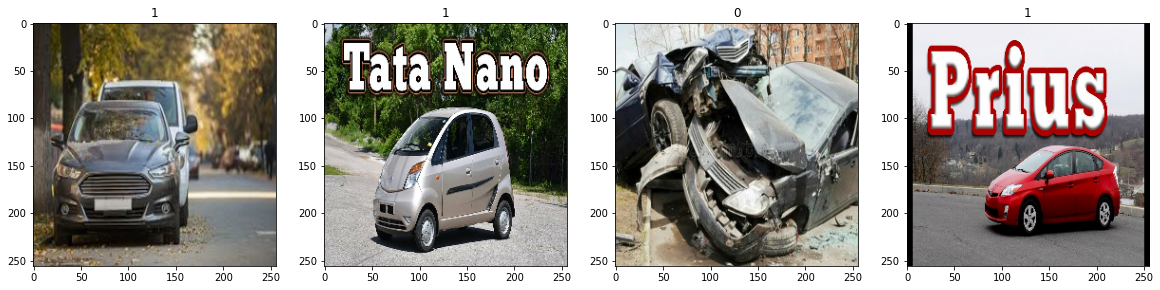

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.15431985, 0.16216299, 0.15039828],
          [0.40158165, 0.40942478, 0.39766008],
          [0.16760111, 0.17544425, 0.16367954],
          ...,
          [0.18418735, 0.19987363, 0.10967755],
          [0.2429228 , 0.26253062, 0.14488357],
          [0.27663526, 0.29232153, 0.18643919]],
 
         [[0.27037376, 0.2782169 , 0.26928616],
          [0.12403876, 0.1318819 , 0.12295114],
          [0.11786152, 0.12570466, 0.1167739 ],
          ...,
          [0.23704045, 0.2527267 , 0.16253063],
          [0.2540786 , 0.27226946, 0.15887332],
          [0.32026654, 0.33595282, 0.235409  ]],
 
         [[0.26875383, 0.27659696, 0.2726754 ],
          [0.40493643, 0.41277957, 0.408858  ],
          [0.09108073, 0.09892387, 0.0950023 ],
          ...,
          [0.23029642, 0.24598269, 0.15578662],
          [0.22536382, 0.2410501 , 0.14250536],
          [0.31758195, 0.33326823, 0.24256663]],
 
         ...,
 
         [[0.15123315, 0.16666667, 0.18810892],
          [0.16192

# Splitting the data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [20]:
model = Sequential()

In [21]:
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)

94765736/94765736 [==============================] - 5s 0us/step


In [22]:
model.add(Flatten())
model.add(Dense(256, activation='LeakyReLU'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile('adamax', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,112,513
Trainable params: 524,801
Non-trainable params: 23,587,712
_________________________________________________________________


In [25]:
hist = model.fit(train, epochs=30, validation_data=val)

Epoch 1/30
7/7 [==============================] - 19s 835ms/step - loss: 5.8579 - accuracy: 0.4554 - val_loss: 5.0044 - val_accuracy: 0.4583
Epoch 2/30
7/7 [==============================] - 7s 702ms/step - loss: 3.0467 - accuracy: 0.4732 - val_loss: 0.9402 - val_accuracy: 0.5000
Epoch 3/30
7/7 [==============================] - 7s 693ms/step - loss: 1.2460 - accuracy: 0.6161 - val_loss: 1.0617 - val_accuracy: 0.5312
Epoch 4/30
7/7 [==============================] - 7s 702ms/step - loss: 1.0210 - accuracy: 0.5625 - val_loss: 1.1558 - val_accuracy: 0.5417
Epoch 5/30
7/7 [==============================] - 7s 694ms/step - loss: 0.8114 - accuracy: 0.6027 - val_loss: 0.5345 - val_accuracy: 0.7500
Epoch 6/30
7/7 [==============================] - 7s 704ms/step - loss: 0.5528 - accuracy: 0.7232 - val_loss: 0.4626 - val_accuracy: 0.7500
Epoch 7/30
7/7 [==============================] - 7s 699ms/step - loss: 0.5507 - accuracy: 0.7143 - val_loss: 0.4918 - val_accuracy: 0.8021
Epoch 8/30
7/7 [===

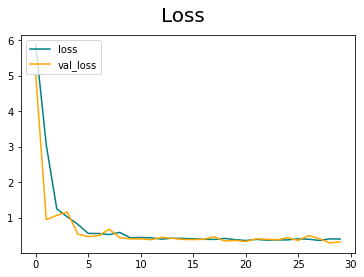

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

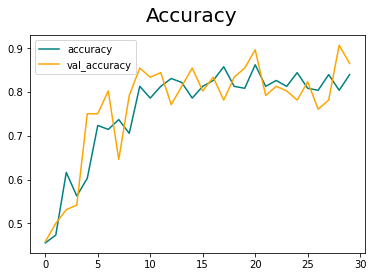

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# **Evaluation**

In [30]:
from tensorflow.keras.metrics import BinaryAccuracy
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    acc.update_state(y, yhat)

1/1 [==============================] - 2s 2s/step


In [32]:
print(f"Training Accuracy Of Model   : {round(acc.result().numpy()*100,2)}%")

Training Accuracy Of Model   : 77.78%


# Test Model with unkown data

In [33]:
def cust_test(path):
  img = cv2.imread(path)

  plt.imshow(img)
  
  resized_img = tf.image.resize(img, (256,256))
  #plt.imshow(resized_img.numpy().astype(int))
  #plt.show()
  prediction = model.predict(np.expand_dims(resized_img/255, 0),verbose=0)

  if prediction > 0.5: 
      plt.title(label='Non-Crash',fontsize=20,color="green")
  else:
      plt.title(label='Crash',fontsize=20,color="red")
  plt.show()

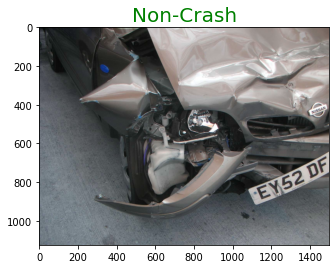

In [ ]:
cust_test('/content/test_img.jpg')

# Save model


In [35]:
from tensorflow.keras.models import load_model
model.save(os.path.join('','car-crash-classifier-v2(89.77-87).h5'))